## Recurrent Neural Netowrk implementation for classifying Fake News

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional,GRU
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# tf.__version__
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.shape

(20800, 5)

In [ ]:
train_df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


<Axes: xlabel='label', ylabel='count'>

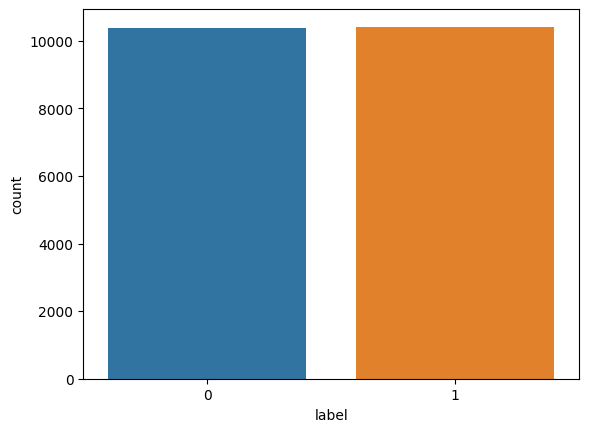

In [ ]:
sns.countplot(x=train_df['label'])

In [ ]:
train_df['title'][100]

'Technocracy: The Real Reason Why The UN Wants Control Over The Internet'

In [ ]:
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
train_df.dropna(inplace=True)

# Data preprocessing

In [ ]:
X = train_df.drop("label", axis = 1)

In [ ]:
y=train_df['label']

In [ ]:
X.shape

(18285, 4)

In [ ]:
y.shape

(18285,)

In [ ]:
title_txt = X.copy()

In [ ]:
title_txt.reset_index(inplace=True)

Stemming

In [ ]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(title_txt)):
    review = re.sub('[^a-zA-Z]', ' ', title_txt['title'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

One-hot Encoding

In [ ]:
voc = 10000
onehot_repr=[one_hot(words,voc)for words in corpus]

In [ ]:
onehot_repr[0]

[2081, 9234, 7374, 3761, 6380, 3841, 9393, 3447, 8873, 4733]

Padding

In [ ]:
sent_length=25
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 3447 8873 4733]
 [   0    0    0 ... 7705 9470  645]
 [   0    0    0 ... 3846 2368 5340]
 ...
 [   0    0    0 ... 4167 5172 4895]
 [   0    0    0 ... 1187 2631 1945]
 [   0    0    0 ...  675 7144 7370]]


In [ ]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 2081, 9234, 7374, 3761, 6380, 3841, 9393,
       3447, 8873, 4733], dtype=int32)

In [ ]:
embedded_docs.shape

(18285, 25)

Variable Declaration

In [ ]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(12799, 25)
(12799,)


# RNN Model

In [ ]:
## Creating 1 st RNN model
embedding_vector_features=40
rnn = Sequential()
rnn.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
rnn.add(SimpleRNN(100,return_sequences=False))
rnn.add(Dense(1, activation='sigmoid'))

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            400000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               14100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 414201 (1.58 MB)
Trainable params: 414201 (1.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnnModel = rnn.fit(X_train, y_train,epochs=20,batch_size=32,validation_data=(X_test,y_test))

Epoch 1/20
400/400 [==============================] - 9s 19ms/step - loss: 0.2626 - accuracy: 0.8867 - val_loss: 0.1873 - val_accuracy: 0.9218
Epoch 2/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0806 - accuracy: 0.9717 - val_loss: 0.2068 - val_accuracy: 0.9151
Epoch 3/20
400/400 [==============================] - 7s 18ms/step - loss: 0.0163 - accuracy: 0.9955 - val_loss: 0.2978 - val_accuracy: 0.9050
Epoch 4/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.3447 - val_accuracy: 0.9194
Epoch 5/20
400/400 [==============================] - 7s 19ms/step - loss: 9.4191e-04 - accuracy: 0.9998 - val_loss: 0.4096 - val_accuracy: 0.9149
Epoch 6/20
400/400 [==============================] - 7s 19ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.4171 - val_accuracy: 0.9171
Epoch 7/20
400/400 [==============================] - 7s 17ms/step - loss: 1.7030e-04 - accuracy: 1.0000 - val_loss: 0.4395 - val_accuracy

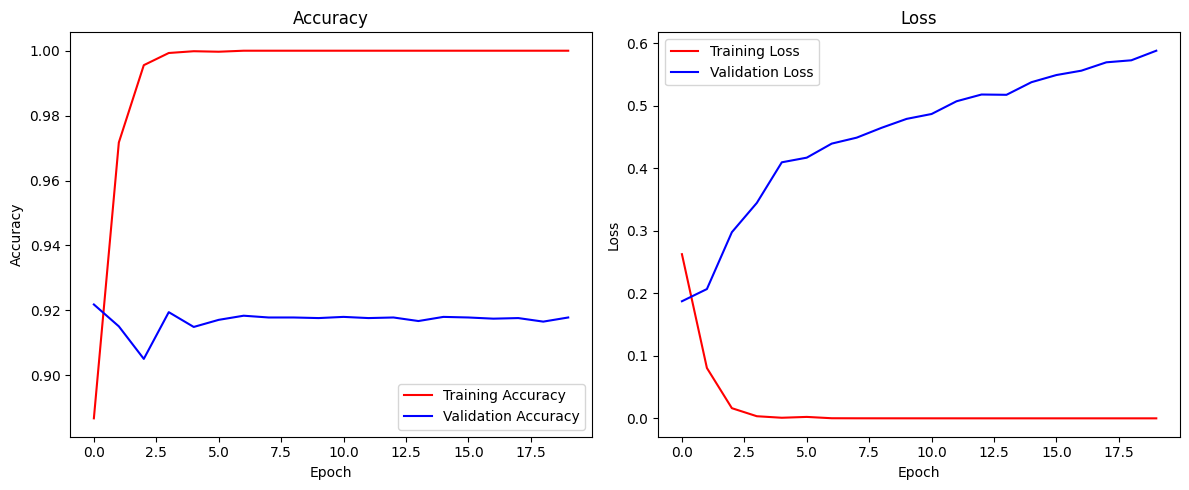

In [ ]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)
plt.plot(rnnModel.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(rnnModel.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)
plt.plot(rnnModel.history["loss"], label="Training Loss", c="red")
plt.plot(rnnModel.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()
plt.show()

## RNN - Evaluation

In [ ]:
y_rnn=rnn.predict(X_test)
y_rnn = (y_rnn>0.5).astype(int)

172/172 [==============================] - 1s 3ms/step


In [ ]:
accuracy_score(y_test,y_rnn)

0.9177907400656216

In [ ]:
confusion_matrix(y_test,y_rnn)

array([[2814,  293],
       [ 158, 2221]])

In [ ]:
print(classification_report(y_test,y_rnn))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3107
           1       0.88      0.93      0.91      2379

    accuracy                           0.92      5486
   macro avg       0.92      0.92      0.92      5486
weighted avg       0.92      0.92      0.92      5486



# With LSTM

In [ ]:
#RNN Model with lstm
embedding_vector_features=40
lstm=Sequential()
lstm.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
lstm.add(Dropout(0.2))
lstm.add(LSTM(100))
lstm.add(Dropout(0.2))
lstm.add(Dense(1,activation='sigmoid'))


In [ ]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 40)            400000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 456501 (1.74 MB)
Trainable params: 456501 (1.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
rnnModel_lstm = lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
400/400 [==============================] - 18s 36ms/step - loss: 0.2745 - accuracy: 0.8761 - val_loss: 0.2009 - val_accuracy: 0.9205
Epoch 2/20
400/400 [==============================] - 14s 34ms/step - loss: 0.1223 - accuracy: 0.9542 - val_loss: 0.1934 - val_accuracy: 0.9231
Epoch 3/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0773 - accuracy: 0.9724 - val_loss: 0.2684 - val_accuracy: 0.9216
Epoch 4/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0439 - accuracy: 0.9860 - val_loss: 0.2596 - val_accuracy: 0.9189
Epoch 5/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0274 - accuracy: 0.9916 - val_loss: 0.3468 - val_accuracy: 0.9100
Epoch 6/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0185 - accuracy: 0.9949 - val_loss: 0.3522 - val_accuracy: 0.9165
Epoch 7/20
400/400 [==============================] - 14s 34ms/step - loss: 0.0122 - accuracy: 0.9965 - val_loss: 0.4170 - val_accuracy:

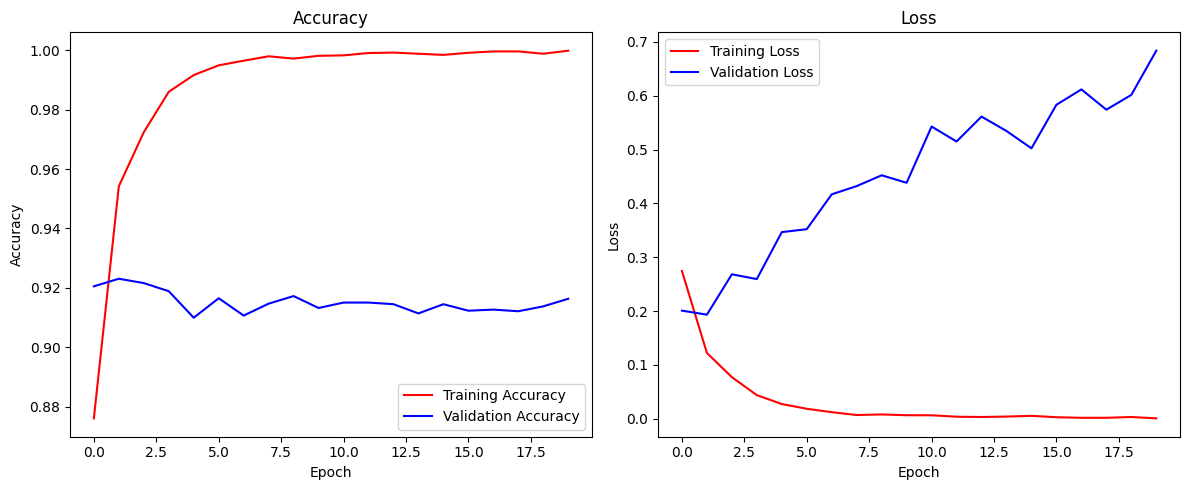

In [ ]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)
plt.plot(rnnModel_lstm.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(rnnModel_lstm.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)
plt.plot(rnnModel_lstm.history["loss"], label="Training Loss", c="red")
plt.plot(rnnModel_lstm.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()
plt.show()

## LSTM -Evaluation

In [ ]:
lstm_rnn=lstm.predict(X_test)
lstm_rnn = (lstm_rnn>0.5).astype(int)

172/172 [==============================] - 2s 8ms/step


In [ ]:
accuracy_score(y_test,lstm_rnn)

0.9163324826831936

In [ ]:
confusion_matrix(y_test,lstm_rnn)

array([[2792,  315],
       [ 144, 2235]])

# With Bidirectional LSTM

In [ ]:
#RNN Model with bidirectional lstm
embedding_vector_features=40
bi_lstm=Sequential()
bi_lstm.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
bi_lstm.add(Dropout(0.3))
bi_lstm.add(Bidirectional(LSTM(100)))
bi_lstm.add(Dropout(0.3))
bi_lstm.add(Dense(1,activation='sigmoid'))


In [ ]:
bi_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 40)            400000    
                                                                 
 dropout_2 (Dropout)         (None, 25, 40)            0         
                                                                 
 bidirectional (Bidirection  (None, 200)               112800    
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 513001 (1.96 MB)
Trainable params: 513001 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
bi_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_bilstm = bi_lstm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
400/400 [==============================] - 27s 56ms/step - loss: 0.2777 - accuracy: 0.8752 - val_loss: 0.1907 - val_accuracy: 0.9254
Epoch 2/20
400/400 [==============================] - 21s 52ms/step - loss: 0.1287 - accuracy: 0.9503 - val_loss: 0.1922 - val_accuracy: 0.9265
Epoch 3/20
400/400 [==============================] - 20s 49ms/step - loss: 0.0851 - accuracy: 0.9697 - val_loss: 0.2158 - val_accuracy: 0.9233
Epoch 4/20
400/400 [==============================] - 22s 54ms/step - loss: 0.0569 - accuracy: 0.9798 - val_loss: 0.2441 - val_accuracy: 0.9189
Epoch 5/20
400/400 [==============================] - 20s 49ms/step - loss: 0.0393 - accuracy: 0.9868 - val_loss: 0.3356 - val_accuracy: 0.9167
Epoch 6/20
400/400 [==============================] - 22s 54ms/step - loss: 0.0311 - accuracy: 0.9890 - val_loss: 0.3784 - val_accuracy: 0.9152
Epoch 7/20
400/400 [==============================] - 20s 51ms/step - loss: 0.0235 - accuracy: 0.9927 - val_loss: 0.3676 - val_accuracy:

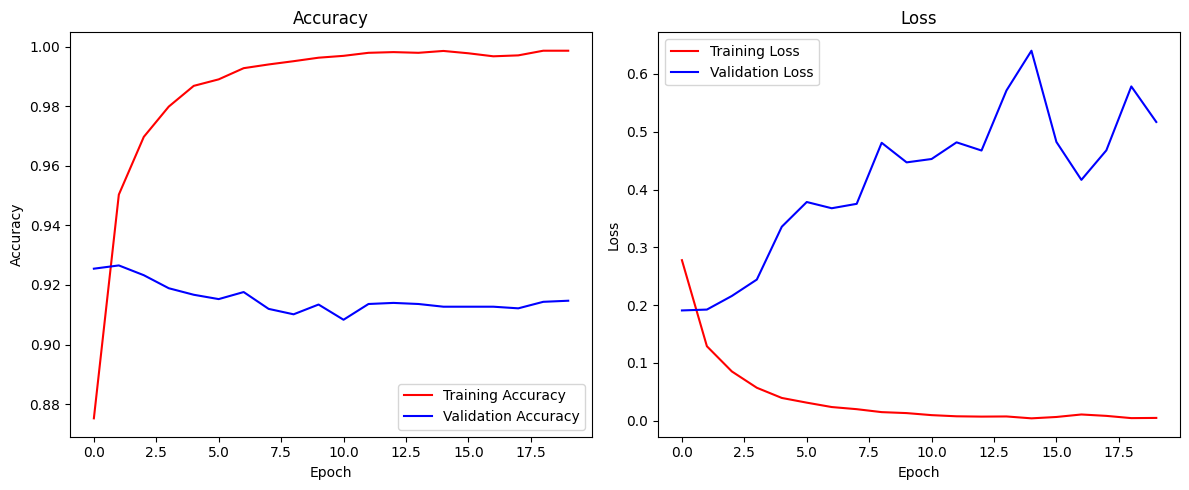

In [ ]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history_bilstm.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history["loss"], label="Training Loss", c="red")
plt.plot(history_bilstm.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()
plt.show()

## Bidirectional LSTM -Evaluation

In [ ]:
bilstm_rnn=bi_lstm.predict(X_test)
bilstm_rnn = (bilstm_rnn>0.5).astype(int)

172/172 [==============================] - 4s 18ms/step


In [ ]:
accuracy_score(y_test,bilstm_rnn)

0.9146919431279621

In [ ]:
confusion_matrix(y_test,bilstm_rnn)

array([[2856,  251],
       [ 217, 2162]])

# GRU (Gated Recurrent Unit)

In [ ]:
#RNN Model with GRU
embedding_vector_features=40
gru=Sequential()
gru.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
gru.add(Dropout(0.3))
gru.add(Bidirectional(GRU(100)))
gru.add(Dropout(0.3))
gru.add(Dense(1,activation='sigmoid'))

In [ ]:
gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 40)            400000    
                                                                 
 dropout_4 (Dropout)         (None, 25, 40)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               85200     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 485401 (1.85 MB)
Trainable params: 485401 (1.85 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history_gru = gru.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32)

Epoch 1/20
400/400 [==============================] - 27s 56ms/step - loss: 0.2606 - accuracy: 0.8764 - val_loss: 0.1901 - val_accuracy: 0.9180
Epoch 2/20
400/400 [==============================] - 20s 50ms/step - loss: 0.1200 - accuracy: 0.9530 - val_loss: 0.1954 - val_accuracy: 0.9240
Epoch 3/20
400/400 [==============================] - 21s 52ms/step - loss: 0.0688 - accuracy: 0.9753 - val_loss: 0.2236 - val_accuracy: 0.9163
Epoch 4/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0361 - accuracy: 0.9884 - val_loss: 0.3081 - val_accuracy: 0.9189
Epoch 5/20
400/400 [==============================] - 19s 48ms/step - loss: 0.0250 - accuracy: 0.9923 - val_loss: 0.2991 - val_accuracy: 0.9169
Epoch 6/20
400/400 [==============================] - 23s 57ms/step - loss: 0.0172 - accuracy: 0.9945 - val_loss: 0.4105 - val_accuracy: 0.9098
Epoch 7/20
400/400 [==============================] - 19s 48ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.4050 - val_accuracy:

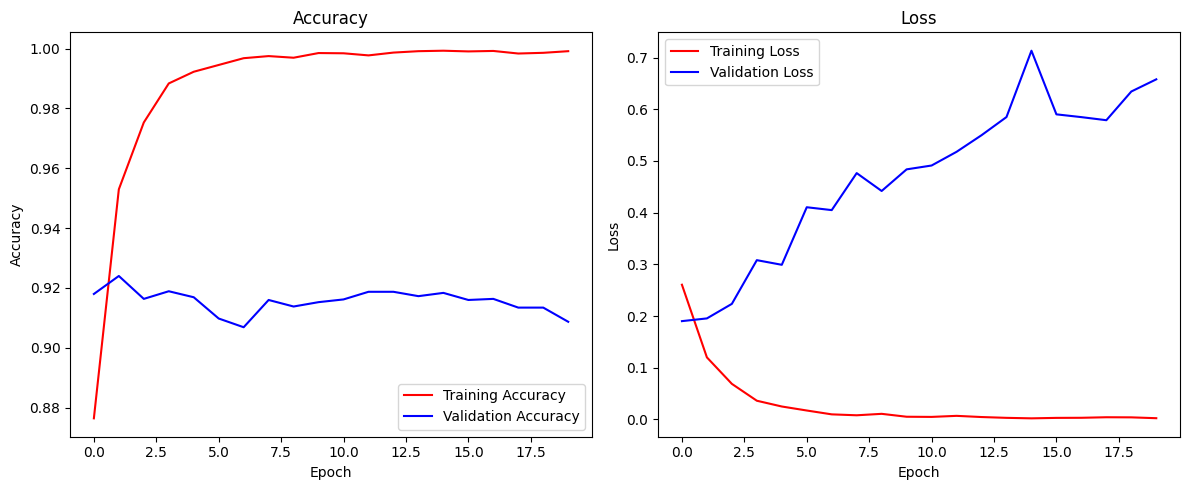

In [ ]:
plt.figure(figsize=(12, 5))

#  Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_gru.history["accuracy"], label="Training Accuracy", c="red")
plt.plot(history_gru.history["val_accuracy"], label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#  Loss
plt.subplot(1, 2, 2)
plt.plot(history_gru.history["loss"], label="Training Loss", c="red")
plt.plot(history_gru.history["val_loss"], label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
gru_rnn=gru.predict(X_test)
gru_rnn = (gru_rnn>0.5).astype(int)

172/172 [==============================] - 2s 10ms/step


In [ ]:
accuracy_score(y_test,gru_rnn)

0.9086766314254466

In [ ]:
confusion_matrix(y_test,gru_rnn)

array([[2876,  231],
       [ 270, 2109]])